In [423]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [525]:
import stats
import data

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler

%matplotlib inline

#### Relevant data RICs and dates

In [474]:
start_date = '2017-01-01'
end_date =  '2019-06-01'

bond_fields = ['TRDPRC_1', 'OPEN_PRC', 'HIGH_1', 'LOW_1']
yield_fields = ['A_YLD_1', 'B_YLD_1', 'HIGH_YLD', 'LOW_YLD']

benchmark_price = data.get_historical_pricing_data('.IDCOT7TR', 'TRDPRC_1', start_date, end_date)

bond_yield_2Y = data.get_historical_pricing_data('US2YT=RR', yield_fields, start_date, end_date)
bond_yield_5Y = data.get_historical_pricing_data('US5YT=RR', yield_fields, start_date, end_date)
bond_yield_10Y = data.get_historical_pricing_data('US10YT=RR', yield_fields, start_date, end_date)

bond_future_2Y = data.get_historical_pricing_data('TUc1', bond_fields, start_date, end_date)
bond_future_5Y = data.get_historical_pricing_data('FVc1', bond_fields, start_date, end_date)
bond_future_10Y = data.get_historical_pricing_data('TYc1', bond_fields, start_date, end_date)

In [475]:
benchmark_price.to_csv('data/benchmark_price.csv')

bond_yield_2Y.to_csv('data/bond_yield_2Y.csv')
bond_yield_5Y.to_csv('data/bond_yield_5Y.csv')
bond_yield_10Y.to_csv('data/bond_yield_10Y.csv')

bond_future_2Y.to_csv('data/bond_future_2Y.csv')
bond_future_5Y.to_csv('data/bond_future_5Y.csv')
bond_future_10Y.to_csv('data/bond_future_10Y.csv')

In [508]:
benchmark_price = pd.read_csv('data/benchmark_price.csv', index_col='DATE')

bond_yield_2Y = pd.read_csv('data/bond_yield_2Y.csv', index_col='DATE')
bond_yield_5Y = pd.read_csv('data/bond_yield_5Y.csv', index_col='DATE')
bond_yield_10Y = pd.read_csv('data/bond_yield_10Y.csv', index_col='DATE')

bond_future_2Y = pd.read_csv('data/bond_future_2Y.csv', index_col='DATE')
bond_future_5Y = pd.read_csv('data/bond_future_5Y.csv', index_col='DATE')
bond_future_10Y = pd.read_csv('data/bond_future_10Y.csv', index_col='DATE')

#### Statistics for the benchmark

All the relevant metrics mentioned in:  
https://ideas.ubs.com/subdomain/bonds-hedging-strategy/end/campaign_overview

------------------------------
Total % Return:        9.293%
Total % Annual Return: 3.883%
Maximum % Drawdown:    -10.027%
Sharpe Ratio:          4.392
------------------------------


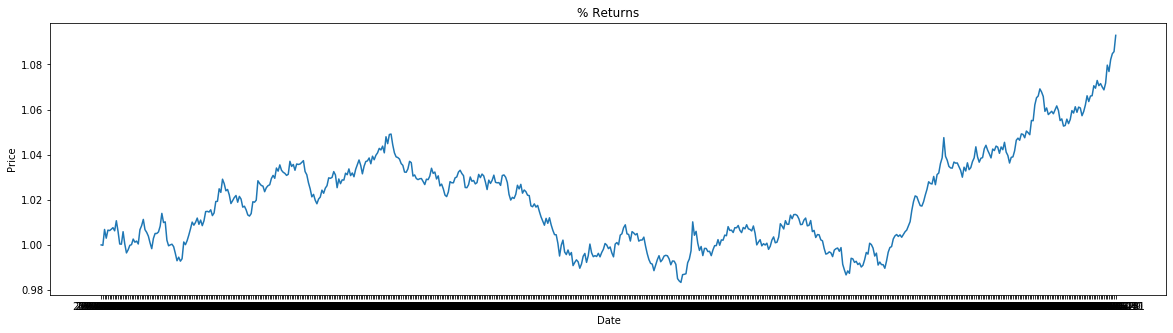

In [542]:
stats.print_full_statistics(benchmark_price['TRDPRC_1'])

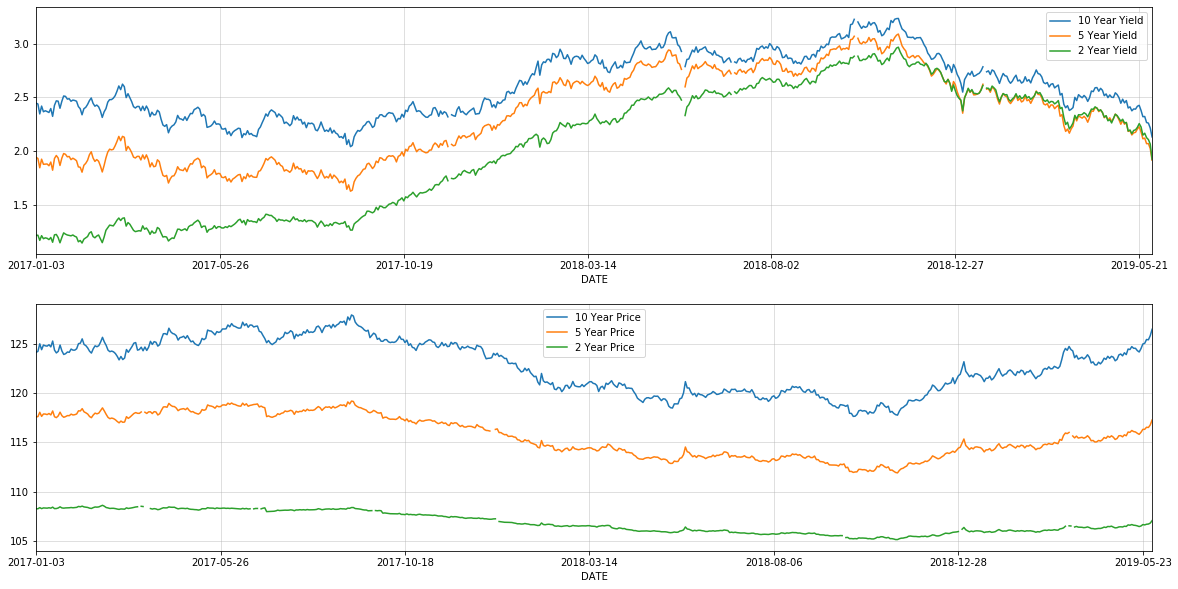

In [510]:
fig, ax = plt.subplots(2, 1, figsize=(20, 10))

bond_yield_10Y['A_YLD_1'].plot(ax=ax[0], label='10 Year Yield')
bond_yield_5Y['A_YLD_1'].plot(ax=ax[0], label='5 Year Yield')
bond_yield_2Y['A_YLD_1'].plot(ax=ax[0], label='2 Year Yield')

bond_future_10Y['TRDPRC_1'].plot(ax=ax[1], label='10 Year Price')
bond_future_5Y['TRDPRC_1'].plot(ax=ax[1], label='5 Year Price')
bond_future_2Y['TRDPRC_1'].plot(ax=ax[1], label='2 Year Price')

ax[0].legend(); ax[0].grid(alpha=0.5)
ax[1].legend(); ax[1].grid(alpha=0.5)

#### Wrangling the data for a reinforcement learning suitable format
The features consists of yields and bond fututres for various years.  
Action space consists of exposures to different bond futures.  
  
All the features are made stationary by first order differencing.  
Then all the features are scaled using a standard scaler.  
Original trade prices are saved in a seperate dataframe for rewards.  

In [511]:
bond_future_10Y = bond_future_10Y.rename({name:name+'_10Y' for name in bond_fields}, axis=1).diff().dropna()
bond_future_5Y = bond_future_5Y.rename({name:name+'_5Y' for name in bond_fields}, axis=1).diff().dropna()
bond_future_2Y = bond_future_2Y.rename({name:name+'_2Y' for name in bond_fields}, axis=1).diff().dropna()

bond_yield_10Y = bond_yield_10Y.rename({name:name+'_10Y' for name in yield_fields}, axis=1).diff().dropna() 
bond_yield_5Y = bond_yield_5Y.rename({name:name+'_5Y' for name in yield_fields}, axis=1).diff().dropna()
bond_yield_2Y = bond_yield_2Y.rename({name:name+'_2Y' for name in yield_fields}, axis=1).diff().dropna()

futures = bond_future_10Y.join(bond_future_5Y).join(bond_future_2Y)
yields = bond_yield_10Y.join(bond_yield_5Y).join(bond_yield_2Y)
all_data = futures.join(yields).dropna()

bond_future_10Y = all_data[[name+'_10Y' for name in bond_fields]]
bond_future_5Y = all_data[[name+'_5Y' for name in bond_fields]]
bond_future_2Y = all_data[[name+'_2Y' for name in bond_fields]]

bond_yield_10Y = all_data[[name+'_10Y' for name in yield_fields]]
bond_yield_5Y = all_data[[name+'_5Y' for name in yield_fields]]
bond_yield_2Y = all_data[[name+'_2Y' for name in yield_fields]]

futures = [bond_future_10Y, bond_future_5Y, bond_future_2Y]
yields = [bond_yield_10Y, bond_yield_5Y, bond_yield_2Y]

In [512]:
rename_dict = {'TRDPRC_1_10Y':'RTN_10Y',
               'TRDPRC_1_5Y':'RTN_5Y',
               'TRDPRC_1_2Y':'RTN_2Y'}

bond_trade_returns = pd.concat([bond_future_10Y['TRDPRC_1_10Y'], bond_future_5Y['TRDPRC_1_5Y'], bond_future_2Y['TRDPRC_1_2Y']], axis=1)
bond_trade_returns.rename(rename_dict, axis=1, inplace=True)

The scaler values will be used in the trading simulation.

In [514]:
futures_scaler = StandardScaler()
yields_scaler = StandardScaler()

for bond in futures:
    futures_scaler.partial_fit(bond)
    
for bond in yields:
    yields_scaler.partial_fit(bond)
    
print('Futures Scaler.')
print(futures_scaler.scale_)
print(futures_scaler.mean_)

print('-'*45)

print('Yields Scaler.')
print(yields_scaler.scale_)
print(yields_scaler.mean_)

Futures Scaler.
[0.19783808 0.20085623 0.1834708  0.15790336]
[-0.00091374 -0.00140945 -0.00125183 -0.00049799]
---------------------------------------------
Yields Scaler.
[0.03356633 0.03230783 0.02613078 0.03109321]
[0.00048193 0.00053684 0.00052515 0.00058947]


In [515]:
futures_scaled = [futures_scaler.transform(bond) for bond in futures]
yields_scaled = [yields_scaler.transform(bond) for bond in yields]

futures = np.concatenate(futures_scaled, axis=1)
yields = np.concatenate(yields_scaled, axis=1)

features = np.concatenate([futures, yields], axis=1)
returns = bond_trade_returns.values

assert returns.shape[0] == features.shape[0]

In [516]:
np.save('rl_env/data/features.npy', features)
np.save('rl_env/data/returns.npy', returns)

In [534]:
features[0]

array([ 0.47849102,  0.08480916,  0.26231328,  1.78430653,  0.1625761 ,
        0.08480916, -0.03575867,  0.94320661,  0.00461864, -0.18746271,
       -0.24866721,  0.15158316, -0.23183739, -0.07852096, -1.55085851,
       -0.17976509, -0.30929596, -0.01661647, -1.01509192, -0.01895828,
       -0.01733671,  0.23100151, -0.32624917,  1.01020532])